# <center> 8. Ridge, Lasso, GridSearch </center>

- using GridSearchCV for Ridge and Lasso regressions
- checking significance of difference of final models

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
##### Jupyter notebook theme setup:
# !pip install jupyterthemes
!jt -t gruvboxd -fs 95 -tfs 11 -nfs 115 -cellw 80% -T
##### Reset theme:
# !jt -r
##### Plot style:
from jupyterthemes import jtplot
jtplot.style()

# Reload page after cell evaluation

# Data Import

In [3]:
# Weather data
df_weather = pd.read_csv('data/weather.csv', sep=',')
df_weather.rename(columns={'DATE': 'Date'}, inplace=True)
df_weather.Date = pd.to_datetime(df_weather.Date)
df_weather.set_index('Date', inplace=True)

In [4]:
# Hourly data on pedastrian walkers
df = pd.read_csv('data/passerbys.csv', sep=',')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
# Day-aggregation
df = df.resample('1D').sum()

In [5]:
# Merging tables
df = pd.merge(df, df_weather, on=['Date'], how='left')
df.head(3)

,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk,TAVG,PRCP
Date,,,,
2012-10-03,1760.0,1761.0,NaN,0.0
2012-10-04,1708.0,1767.0,NaN,0.0
2012-10-05,1558.0,1590.0,NaN,0.0


In [6]:
# Deleting NA
df.info(show_counts=True)
df.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2462 entries, 2012-10-03 to 2019-06-30
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Fremont Bridge East Sidewalk  2462 non-null   float64
 1   Fremont Bridge West Sidewalk  2462 non-null   float64
 2   TAVG                          2280 non-null   float64
 3   PRCP                          2462 non-null   float64
dtypes: float64(4)
memory usage: 96.2 KB


In [7]:
# Short names
df.rename(columns={'Fremont Bridge East Sidewalk': 'East', 'Fremont Bridge West Sidewalk': "West"}, inplace=True)
# Sum of walkers of both bridges
df['walkers'] = df['East'] + df['West']

In [8]:
df.describe()

,East,West,TAVG,PRCP,walkers
count,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000
mean,1284.950000,1474.927632,12.336930,2.910000,2759.877632
std,610.023608,775.775696,5.912745,6.539704,1338.876175
min,19.000000,12.000000,-4.400000,0.000000,38.000000
25%,842.000000,911.750000,8.100000,0.000000,1818.750000
50%,1228.000000,1375.500000,12.100000,0.000000,2613.500000
75%,1750.250000,2067.000000,16.900000,2.500000,3839.000000
max,3143.000000,4050.000000,27.600000,55.900000,6428.000000


In [9]:
# Dropping East and West
df_ready = df
df_ready.drop(['East', 'West'], axis=1, inplace=True)

In [10]:
# Standartization
scaler = StandardScaler()
df_ready = pd.DataFrame(scaler.fit_transform(df_ready), index=df_ready.index, columns=df_ready.columns)

In [11]:
df_ready.head(3)

,TAVG,PRCP,walkers
Date,,,
2013-04-01,0.078334,-0.445072,0.364656
2013-04-02,-0.141578,-0.445072,0.393791
2013-04-03,-0.107745,-0.445072,0.542456


In [12]:
y = df_ready['walkers']
X = df_ready.drop('walkers', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# GridSearchCV. Ridge

In [13]:
ridge = Ridge()
parameters = {
    'alpha': np.arange(0, 20, 0.01)
}

grid_ridge = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=5, n_jobs=(-3))
grid_ridge.fit(X_train, y_train);

In [14]:
grid_ridge.best_params_

{'alpha': 11.1}

In [15]:
ridge_best = Ridge(**grid_ridge.best_params_)
ridge_best.fit(X_train, y_train)
mean_squared_error(y_test, ridge_best.predict(X_test))

0.5928521666806807

<AxesSubplot:xlabel='Date'>

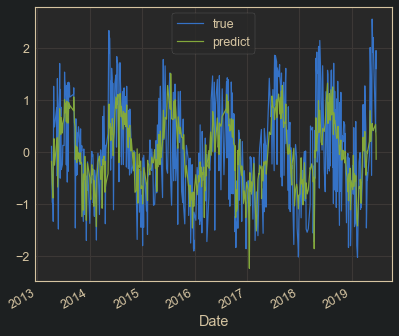

In [16]:
pd.DataFrame({'true': y_test, 'predict': ridge_best.predict(X_test)}).plot()

# GridSearchCV. Lasso

In [17]:
lasso = Lasso()
parameters = {
    'alpha': np.arange(1e-10, 10, 0.005)
}
grid_lasso = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5, n_jobs=(-3))
grid_lasso.fit(X_train, y_train);

In [18]:
grid_lasso.best_params_

{'alpha': 0.0050000001}

In [19]:
lasso_best = Lasso(**grid_lasso.best_params_)
lasso_best.fit(X_train, y_train)
mean_squared_error(y_test, lasso_best.predict(X_test))

0.5929303223892729

<AxesSubplot:xlabel='Date'>

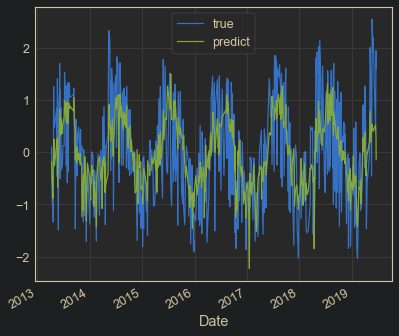

In [20]:
pd.DataFrame({'true': y_test, 'predict': lasso_best.predict(X_test)}).plot()

Results gives almost same quality

### Statistical significance of model differences

In [21]:
# Lets use GridSearch to get MSE on all folds using best parameters
n = 100
grid_lasso_best = GridSearchCV(lasso_best, {}, scoring='neg_mean_squared_error', cv=n, n_jobs=(-1))
grid_lasso_best.fit(X_train, y_train);
grid_ridge_best = GridSearchCV(ridge_best, {}, scoring='neg_mean_squared_error', cv=n, n_jobs=(-1))
grid_ridge_best.fit(X_train, y_train);

In [22]:
ridge_fold_mse = []
for x in range(0, n):
    ridge_fold_mse.append(grid_ridge_best.cv_results_['split' + str(x) + '_test_score'][0])
    
lasso_fold_mse = []
for x in range(0, n):
    lasso_fold_mse.append(grid_lasso_best.cv_results_['split' + str(x) + '_test_score'][0])

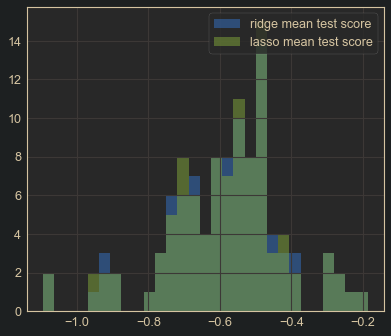

In [23]:
# Ctrl+c from StackOverflow
bins = np.linspace(min(min(ridge_fold_mse), min(lasso_fold_mse)),
                   max(max(ridge_fold_mse), max(lasso_fold_mse)), 30)
plt.hist(ridge_fold_mse, bins, alpha=0.5, label='ridge mean test score')
plt.hist(lasso_fold_mse, bins, alpha=0.5, label='lasso mean test score')
plt.legend(loc='upper right')
plt.show()

~~On picture we can see~~ By Student's test (pvalue > 0.1), hypotesis of equality of mean of two samples is not rejected.

In [24]:
# Проверим гипотезу о равенстве средних
stats.ttest_rel(ridge_fold_mse, lasso_fold_mse)

Ttest_relResult(statistic=0.1484859132654077, pvalue=0.8822613320986885)

So we can conclude that models (Ridge and Lasso) are not significantly different.